In [222]:
import sympy
from sympy import symbols
from sympy.physics.mechanics import inertia, dynamicsymbols, Point, ReferenceFrame, RigidBody, outer, linear_momentum, angular_momentum
from sympy.physics.vector import init_vprinting
from sympy import symbols, sin, cos, tan
from sympy.physics.vector.printing import vpprint, vlatex

from sympy import latex

latexReplaceRules = {
    # r'{\left(t \right)}':r' ',
    r'\frac{d}{d t}':r'\dot',
    r'\frac{d^{2}}{d t^{2}}':r'\ddot',
}
def latexNew(expr,**kwargs):
    retStr = latex(expr,**kwargs)
    for _,__ in latexReplaceRules.items():
        retStr = retStr.replace(_,__)
    return retStr


# Example usage
from sympy import init_printing
init_printing(use_latex=True)

init_printing(latex_printer=latexNew)




In [235]:
# Set up Inertial and Body Frames
ox, oy, oz = dynamicsymbols('omega_x omega_y omega_z')

N = ReferenceFrame('N')

B = N.orientnew('B', 'Body', [0, 0, 0], 'XYZ')

angular_velocity_vector = ox*B.x + oy*B.y + oz*B.z

B.set_ang_vel(N, angular_velocity_vector)
# B.ang_vel_in(N)

# Set up Gyro and Wheel Frames
gamma, Omega = dynamicsymbols('gamma Omega')
# gamma_0 = symbols('gamma_0')

total_gamma = gamma #- gamma_0
t = symbols('t')

G = ReferenceFrame('G')

# Manually set the LaTeX representation for the unit vectors
G.x._latex = lambda self: r'\hat{\mathbf{g}}_{s}'
G.y._latex = lambda self: r'\hat{\mathbf{g}}_{t}'
G.z._latex = lambda self: r'\hat{\mathbf{g}}_{g}'

W = ReferenceFrame('W')

G.orient(B, 'Axis', [total_gamma, B.z])
W.orient(G, 'Axis', [0, G.x])
W.set_ang_vel(G, Omega * G.x)

dcm_BG = B.dcm(G)

In [236]:
# Inetia tensors
I_Gs, I_Gt, I_Gg, I_Ws, I_Wt = symbols('I_{G_s} I_{G_t} I_{G_g} I_{W_s} I_{W_t}')
I_Sx, I_Sy, I_Sz = symbols('I_{S_x} I_{S_y} I_{S_z}')

inertia_sc = inertia(B, I_Sx, I_Sy, I_Sz)
inertia_gyro = inertia(G, I_Gs, I_Gt, I_Gg)
inertia_wheel = inertia(W, I_Ws, I_Wt, I_Wt)

# inertia_gyro.to_matrix(G)

# inertia_wheel.to_matrix(G)

omega_G_B_G = G.ang_vel_in(B).express(G)
omega_W_G_G = W.ang_vel_in(G).express(G)

omega_W_G_G

In [237]:
x,y,z, vx, vy, vz, m_sc, m_g, m_w, l = symbols('x y z v_x v_y v_z m_{sc} m_g m_w l')
position_sc = x*N.x + y*N.y + z*N.z
velocity_sc = vx*N.x + vy*N.y + vz*N.z 

position_vscmg = l*B.z

O = Point('O')
P_sc = O.locatenew('P_{sc}', position_sc)
P_sc.set_vel(N, velocity_sc)

G_cm = P_sc.locatenew('G_{cm}', position_vscmg)
G_cm.set_vel(B, 0) # The COM of the VSCMG is not moving wrt to the spacecraft body frame



spacecraft = RigidBody('SC', P_sc, B, m_sc, (inertia_sc, P_sc))
gyro = RigidBody('Gyro', G_cm, G, m_g, (inertia_gyro, G_cm))
wheel = RigidBody('Wheel', G_cm, W, m_w, (inertia_wheel, G_cm))

# SC.kinetic_energy(N)
omega, omega_s, omega_t, omega_g = dynamicsymbols('omega omega_s omega_t omega_g')

definition = {
    G.x.dot(angular_velocity_vector) : omega_s ,
    G.y.dot(angular_velocity_vector) : omega_t,
    G.z.dot(angular_velocity_vector) : omega_g,
    # omega_s * G.x + omega_t * G.y + omega_g * G.z : omega
}

# definition = {
#     omega_s * G.x + omega_t * G.y + omega_g * G.z : omega
# }

H_B = spacecraft.angular_momentum(P_sc, N).express(B).subs(definition)
H_G = gyro.angular_momentum(G_cm, N).subs(definition)
H_W = wheel.angular_momentum(G_cm, N).subs(definition)



init_printing(latex_printer=latexNew)

H_G.diff(t,N).express(G).simplify()


In [238]:
H_W.diff(t, N).express(G).simplify().to_matrix(G)

⎡          d                  d                         d          ⎤
⎢  I_{W_s}⋅──(Ω(t)) + I_{W_s}⋅──(ωₛ(t)) - I_{W_t}⋅ωₜ(t)⋅──(γ(t))   ⎥
⎢          dt                 dt                        dt         ⎥
⎢                                                                  ⎥
⎢             d                        d                  d        ⎥
⎢I_{W_s}⋅Ω(t)⋅──(γ(t)) + I_{W_s}⋅ωₛ(t)⋅──(γ(t)) + I_{W_t}⋅──(ωₜ(t))⎥
⎢             dt                       dt                 dt       ⎥
⎢                                                                  ⎥
⎢                         ⎛  2                   ⎞                 ⎥
⎢                         ⎜ d          d         ⎟                 ⎥
⎢                 I_{W_t}⋅⎜───(γ(t)) + ──(ω_g(t))⎟                 ⎥
⎢                         ⎜  2         dt        ⎟                 ⎥
⎣                         ⎝dt                    ⎠                 ⎦

In [239]:
gs_dot = G.x.dt(N).subs(definition)
gt_dot = G.y.dt(N).subs(definition)
gg_dot = G.z.dt(N).subs(definition)

domega_s = (gs_dot.dot(angular_velocity_vector) + G.x.dot(angular_velocity_vector.dt(N))).subs(definition).simplify()
domega_t = (gt_dot.dot(angular_velocity_vector) + G.y.dot(angular_velocity_vector.dt(N))).subs(definition).simplify()
domega_g = (gg_dot.dot(angular_velocity_vector) + G.z.dot(angular_velocity_vector.dt(N))).subs(definition).simplify()


H_G.diff(t,N).express(G).simplify()

In [263]:
Omega.diff(t)

In [267]:
angular_velocity_vector.diff(t,N)

In [275]:
J_s, J_t, J_g  = (inertia_gyro + inertia_wheel).to_matrix(G).diagonal()
J = inertia(G, J_s, J_t, J_g)


spin_control_torque = dynamicsymbols('u_s')
gimbal_torque = dynamicsymbols('u_g')

definition3 = {
    I_Ws*(Omega.diff(t) + G.x.dot(angular_velocity_vector.diff(t,N)) + gamma.diff(t)*omega_t) : spin_control_torque,
    J_g*(G.z.dot(angular_velocity_vector.diff(t,N)) + gamma.diff(t).diff(t)) - (J_s - J_t)*omega_s*omega_t - I_Ws*Omega*omega_t: gimbal_torque
}

definition4 = {
    I_Gg + I_Wt : J_g,
    I_Gs + I_Ws : J_s,
    I_Gt + I_Wt : J_t
}



In [274]:
J

In [256]:
dH_B = H_B.dt(N).subs(definition).simplify()
dH_G = H_G.dt(N).subs(definition).simplify()
dH_W = H_W.dt(N).subs(definition).simplify()



In [279]:
(dH_G + dH_B + dH_W).simplify().subs(definition4).simplify()

In [116]:
definition2 = {
    omega_s * G.x + omega_t * G.y + omega_g * G.z : omega
    
}

from sympy.physics.mechanics import time_derivative

H = H_B + H_G + H_W


gs_dot = G.x.dt(N).subs(definition)
gt_dot = G.y.dt(N).subs(definition)
gg_dot = G.z.dt(N).subs(definition)



In [132]:
H.diff(t, N).express(G).subs(definition2)

SympifyError: SympifyError: omega_s(t)*G.x + omega_t(t)*G.y + omega_g(t)*G.z

In [101]:
G.z.dt(N).subs(definition)

AttributeError: 'omega_s' object has no attribute 'dt'

In [101]:
N = ReferenceFrame('N')
Y = N.orientnew('Y', 'Axis', [q1, N.z])
L = Y.orientnew('L', 'Axis', [q2, Y.x])
R = L.orientnew('R', 'Axis', [q3, L.y])
w_R_N_qd = R.ang_vel_in(N)
R.set_ang_vel(N, u1 * L.x + u2 * L.y + u3 * L.z)

In [102]:
R.ang_vel_in(N)

In [103]:
C = Point('C')
C.set_vel(N, 0)
Dmc = C.locatenew('Dmc', r * L.z)
Dmc.v2pt_theory(C, N, R)

In [104]:
I = inertia(L, m / 4 * r**2, m / 2 * r**2, m / 4 * r**2)
I

In [106]:
kd = [dot(R.ang_vel_in(N) - w_R_N_qd, uv) for uv in L]

In [109]:
ForceList = [(Dmc, - m * g * Y.z)]
BodyD = RigidBody('BodyD', Dmc, R, m, (I, Dmc))
BodyList = [BodyD]

In [110]:
KM = KanesMethod(N, q_ind=[q1, q2, q3], u_ind=[u1, u2, u3], kd_eqs=kd)
(fr, frstar) = KM.kanes_equations(BodyList, ForceList)
MM = KM.mass_matrix
forcing = KM.forcing
rhs = MM.inv() * forcing
kdd = KM.kindiffdict()
rhs = rhs.subs(kdd)
rhs.simplify()
rhs

⎡                              2        ⎤
⎢4⋅g⋅sin(q₂) + 6⋅r⋅u₂⋅u₃ - r⋅u₃ ⋅tan(q₂)⎥
⎢───────────────────────────────────────⎥
⎢                  5⋅r                  ⎥
⎢                                       ⎥
⎢               -2⋅u₁⋅u₃                ⎥
⎢               ─────────               ⎥
⎢                   3                   ⎥
⎢                                       ⎥
⎣        (-2⋅u₂ + u₃⋅tan(q₂))⋅u₁        ⎦

In [112]:
t, h0, v0, g, vp, q = symbols('t h_0 v_0 g v_p q', real=True, positive=True)


In [114]:
ho = h0 - v0*t - sympy.Rational(1,2)*g*t**2
dhodt = g*t - v0
hp = vp*t + sympy.Rational(1,2)*q*t**2
dhpdt = vp + q*t


In [115]:
eq1 = ho - hp
eq2 = dhodt + dhpdt


In [117]:
t_collide, v_initfall = sympy.solve([eq1,eq2],[t, v0])[0]

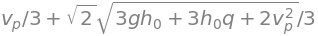

In [118]:
v_initfall

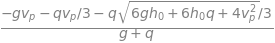

In [121]:
dhodt.subs([(t, t_collide),(v0, v_initfall)]).simplify()